# KdV equation

In [1]:
import sys
import os
sys.path.append("./src")

In [2]:
import jax
import jax.numpy as jnp
import optax
from Data import *
from Plot import *
from NeuralNetwork import *
from InitialFit import *
from Solver import *

### Setup

In [3]:
# Exact solution

def exactKdVTwoSol(x, t):
    '''
    Function taken from https://github.com/pehersto/ng/solvers/exactKdV.py
    Args:
        x: jnp.array, points in space
        t: jnp.array (or float), points in time
    '''

    k = jnp.asarray([1., jnp.sqrt(5.)])
    eta = jnp.asarray([0., 10.73])
    t = jnp.asarray(t) # in case t is a float

    etaMat1 = k[0] * x.reshape((-1, 1)) - k[0] ** 3 * t.reshape((1, -1)) + eta[0]
    etaMat2 = k[1] * x.reshape((-1, 1)) - k[1] ** 3 * t.reshape((1, -1)) + eta[1]
    c = ((k[0] - k[1]) / (k[0] + k[1]) )** 2

    f = 1. + jnp.exp(etaMat1) + jnp.exp(etaMat2) + jnp.multiply(jnp.exp(etaMat1), jnp.exp(etaMat2) * c)
    df = k[0] * jnp.exp(etaMat1) + k[1] * jnp.exp(etaMat2) + c * (k[0] + k[1]) * jnp.multiply(jnp.exp(etaMat1), jnp.exp(etaMat2))
    ddf = k[0] ** 2 * jnp.exp(etaMat1) + k[1] ** 2 * jnp.exp(etaMat2) + c * (k[0] + k[1]) ** 2 * jnp.multiply(jnp.exp(etaMat1), jnp.exp(etaMat2))

    y = 2 * jnp.divide(jnp.multiply(f, ddf) - df ** 2, f ** 2)

    y = jnp.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0) # avoid numerical errors far outside of [-1, 2]
    
    return y

In [4]:
# Problem and training data

problem_data = ProblemData(name='kdv', # problem name
                           d=1, # input dimension
                           domain=(-20, 40), # 1D: (lower, upper)
                           T=4, # final time
                           initial_fn=lambda x: exactKdVTwoSol(x, 0), # initial condition
                           exact_sol=exactKdVTwoSol, # exact solution
                           N=2048, # number of spatial points
                           dt=1.0, # time step (not needed here, we use an adaptive step with RK45)
                          )

training_data = TrainingData(m=10, # number of neurons per layer
                             batch_size=5000, # batch size
                             epochs=10000, # number of epochs
                             gamma=0.1, # learning rate
                             seed=0, # seed for reproducibility
                             scheduler=optax.exponential_decay(init_value=0.1, transition_steps=1000, decay_rate=0.9) # learning rate scheduler
                             # scheduler=optax.linear_schedule(init_value=0.1, end_value=0.001, 
                             #                                 transition_steps=1000, transition_begin=1000) # learning rate scheduler
                             # scheduler=optax.piecewise_constant_schedule(init_value=0.1, boundaries_and_scales={1000: 0.1}) # learning rate scheduler
                            )

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


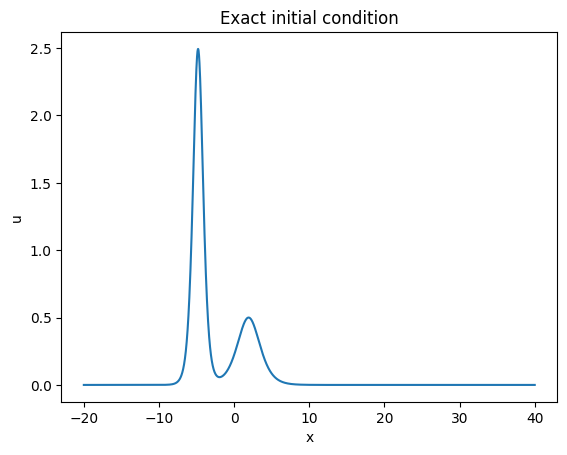

In [5]:
plot_function(problem_data.initial_fn, problem_data, 'Exact initial condition')

In [6]:
print(problem_data)

Problem data:
  name: kdv, d: 1, domain: (-20, 40), T: 4, N: 2048, dt: 1.0


In [7]:
print(training_data)

Training data:
  m: 10, batch size: 5000, epochs: 10000, gamma: 0.1, seed: 0, scheduler: <function exponential_decay.<locals>.schedule at 0x7fb2b82b44c0>


In [8]:
# Neural network

net = ShallowNetKdV(training_data.m, problem_data.domain[1] - problem_data.domain[0])
print(net)

ShallowNetKdV(
    # attributes
    m = 10
    L = 60
)


### Initial fit

In [9]:
# Initial fit

initial_fit = False # True to train a NN to fit the initial condition, False otherwise

if initial_fit:
    theta = init_neural_galerkin(net, problem_data, training_data) # train a NN to fit the initial condition
    jnp.save('./data/theta_init_' + problem_data.name + '_' + str(training_data.seed) + '.npy', theta)
else:
    theta = jnp.load('./data/theta_init_' + problem_data.name + '_' + str(training_data.seed) + '.npy', allow_pickle=True).item()
    x_plot = jnp.linspace(problem_data.domain[0], problem_data.domain[1], problem_data.N)
    relative_error = jnp.linalg.norm(net.apply(theta, x_plot.reshape(-1, 1)) - exactKdVTwoSol(x_plot, 0)) / jnp.linalg.norm(exactKdVTwoSol(x_plot, 0))
    print("Relative error of the initial fit:", relative_error)

Relative error of the initial fit: 0.0059745763


### Time evolution

In [10]:
# Source term for the KdV equation

def rhs_kdv(theta_flat, x, t, u_fn):
    U = jax.vmap(u_fn, (None, 0)) # jax.vmap(fun, in_axes)
    U_dx = jax.vmap(gradsqz(u_fn, 1), (None, 0))
    U_dddx = jax.vmap(gradsqz(gradsqz(gradsqz(u_fn, 1), 1), 1), (None, 0))
    u = U(theta_flat, x)
    u_x = U_dx(theta_flat, x)
    u_xxx = U_dddx(theta_flat, x)
    return - u_xxx - 6 * u * u_x

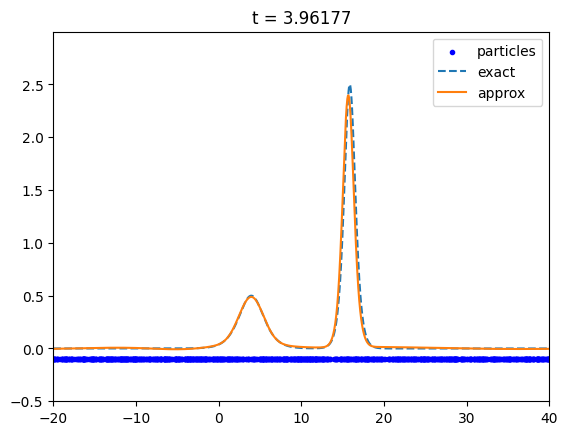

  t = 3.96177
  t = 3.97151
  t = 3.98303
  t = 3.99644


In [18]:
solution, timesteps = neural_galerkin(theta=theta, # initial parameters
                                      net=net, # neural network
                                      problem_data=problem_data, # problem data
                                      n=1000, # sample points
                                      rhs=rhs_kdv, # problem RHS
                                      x_init=None,
                                      sampler='uniform',
                                      scheme='rk45'
                                     )

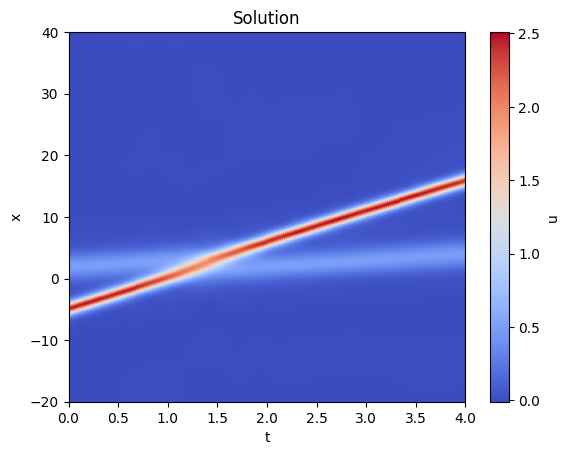

In [12]:
plot_solution(solution, timesteps, problem_data)

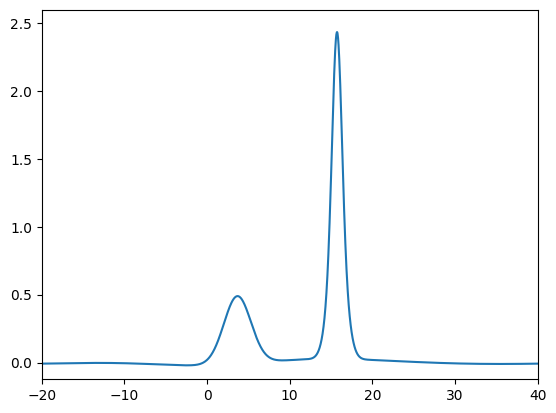

In [15]:
plot_animation(solution, timesteps, problem_data)

### Compute relative error

In [13]:
errors = compute_error(solution, timesteps, exactKdVTwoSol, problem_data)

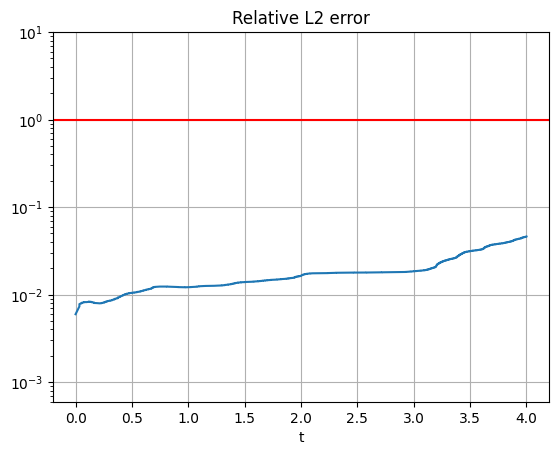

In [14]:
plot_error(errors, timesteps, 'Relative L2 error for NG')

### Comparison with linear fitted Neural Galerkin

In [18]:
training_data_linear = TrainingData(m=30, # number of neurons per layer
                                    batch_size=5000, # batch size
                                    epochs=2000, # number of epochs
                                    gamma=0.1, # learning rate
                                    seed=0, # seed for reproducibility
                                    scheduler=optax.exponential_decay(init_value=0.1, transition_steps=1000, decay_rate=0.9) # learning rate scheduler
                                    # scheduler=optax.piecewise_constant_schedule(init_value=0.1, boundaries_and_scales={1000: 0.1}) # learning rate scheduler
                                   )

net_linear = ShallowNetKdV(training_data_linear.m, problem_data.domain[1] - problem_data.domain[0])

In [32]:
initial_fit = False

if initial_fit:
    theta_linear = init_neural_galerkin(net_linear, problem_data, training_data_linear) # train a NN to fit the initial condition
    jnp.save('./data/theta_init_' + problem_data.name + '_linear_' + str(training_data.seed) + '.npy', theta_linear)
else:
    theta_linear = jnp.load('./data/theta_init_' + problem_data.name + '_linear_' + str(training_data.seed) + '.npy', allow_pickle=True).item()
    x_plot = jnp.linspace(problem_data.domain[0], problem_data.domain[1], problem_data.N)
    relative_error = jnp.linalg.norm(net_linear.apply(theta_linear, x_plot.reshape(-1, 1)) - exactKdVTwoSol(x_plot, 0)) / jnp.linalg.norm(exactKdVTwoSol(x_plot, 0))
    print("Relative error of the initial fit:", relative_error)

Relative error of the initial fit: 1.1953039


In [33]:
# Redefine the NN to freeze the parameters of the periodic unit

net_linear = ShallowNetKdVLinear(training_data_linear.m, problem_data.domain[1] - problem_data.domain[0], 
                                 theta_linear['params']['PeriodicPhiKdV_0']['kernel'], # weights
                                 theta_linear['params']['PeriodicPhiKdV_0']['bias'] # biases
                                )

theta_linear = {'params': {'Dense_0': theta_linear['params']['Dense_0']}}

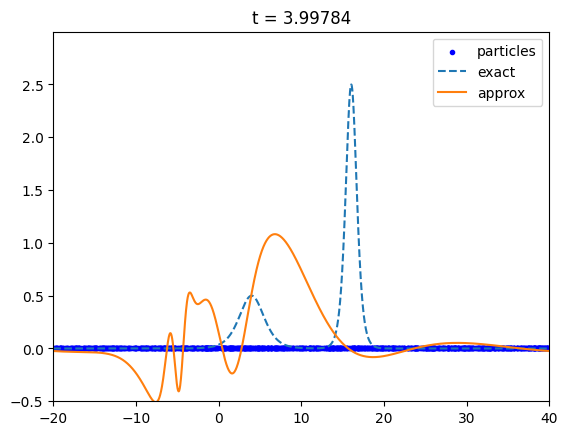

  t = 3.99784


In [37]:
solution_linear, timesteps_linear = neural_galerkin(theta=theta_linear, # initial parameters
                                                    net=net_linear, # neural network
                                                    problem_data=problem_data, # problem data
                                                    n=1000, # sample points
                                                    rhs=rhs_kdv, # problem RHS
                                                    x_init=None,
                                                    sampler='uniform',
                                                    scheme='rk45'
                                                   )

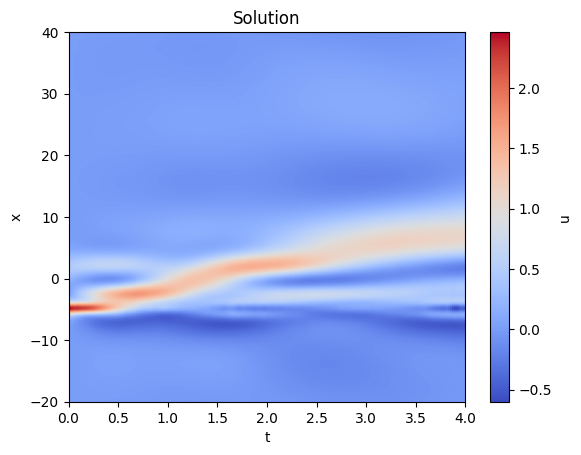

In [38]:
plot_solution(solution_linear, timesteps_linear, problem_data)

In [24]:
errors_linear = compute_error(solution_linear, timesteps_linear, exactKdVTwoSol, problem_data)

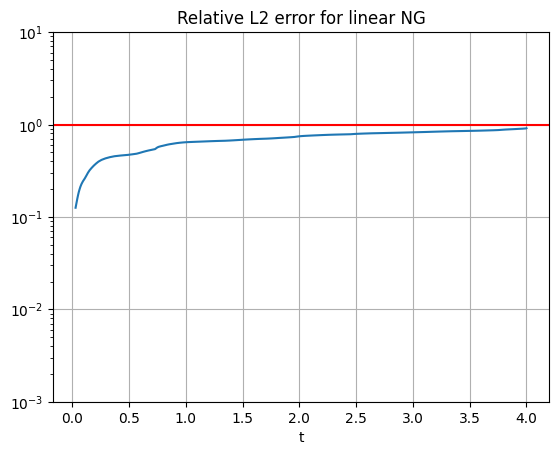

In [25]:
plot_error(errors_linear,timesteps_linear, 'Relative L2 error for linear NG')

### Comparison with linear equidistant Neural Galerkin

In [54]:
net_equi = ShallowNetKdVLinear(training_data_linear.m, problem_data.domain[1] - problem_data.domain[0], 
                               12 * jnp.ones(training_data_linear.m), # weights
                               jnp.linspace(problem_data.domain[0], problem_data.domain[1], training_data_linear.m).reshape(-1, 1) # biases
                              )

In [56]:
initial_fit = False

if initial_fit:
    theta_equi = init_neural_galerkin(net_equi, problem_data, training_data_linear) # train a NN to fit the initial condition
    jnp.save('./data/theta_init_' + problem_data.name + '_equi_' + str(training_data_linear.seed) + '.npy', theta_equi)
else:
    theta_equi = jnp.load('./data/theta_init_' + problem_data.name + '_equi_' + str(training_data_linear.seed) + '.npy', allow_pickle=True).item()
    x_plot = jnp.linspace(problem_data.domain[0], problem_data.domain[1], problem_data.N)
    relative_error = jnp.linalg.norm(net_equi.apply(theta_equi, x_plot.reshape(-1, 1)) - exactKdVTwoSol(x_plot, 0)) / jnp.linalg.norm(exactKdVTwoSol(x_plot, 0))
    print("Relative error of the initial fit:", relative_error)

Relative error of the initial fit: 0.4086522


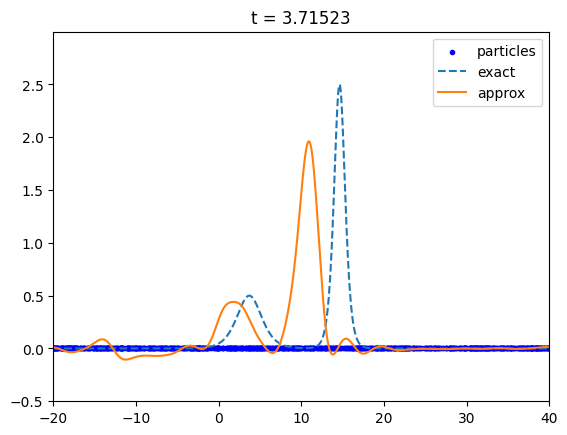

  t = 3.71523
  t = 3.78016
  t = 3.84333
  t = 3.90534
  t = 3.96190


In [57]:
solution_equi, timesteps_equi = neural_galerkin(theta=theta_equi, # initial parameters
                                                net=net_equi, # neural network
                                                problem_data=problem_data, # problem data
                                                n=1000, # sample points
                                                rhs=rhs_kdv, # problem RHS
                                                x_init=None,
                                                sampler='uniform',
                                                scheme='rk45'
                                               )

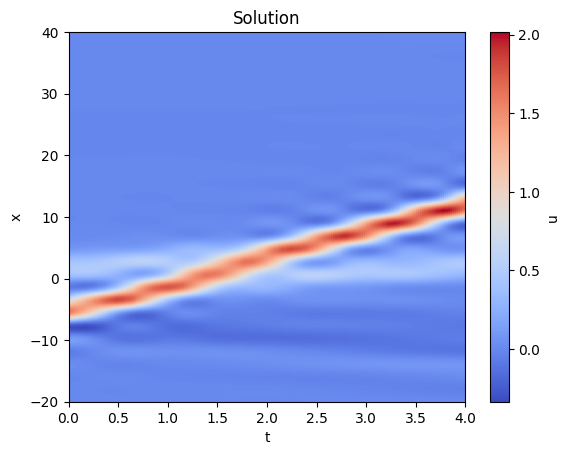

In [58]:
plot_solution(solution_equi, timesteps_equi, problem_data)

In [33]:
errors_equi = compute_error(solution_equi, timesteps_equi, exactKdVTwoSol, problem_data)

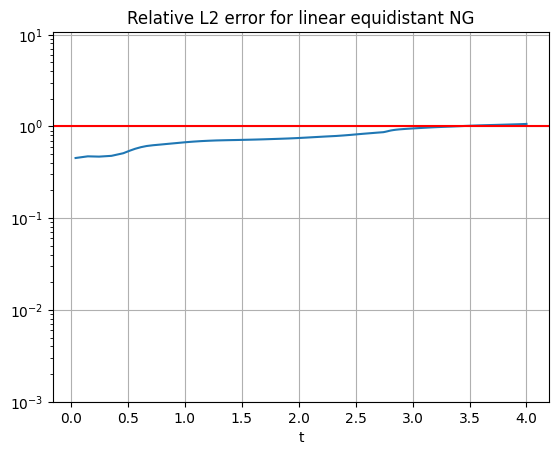

In [34]:
plot_error(errors_equi, timesteps_equi, 'Relative L2 error for linear equidistant NG')

### Comparison with Neural Galerkin with adaptive measure

In [11]:
# Accept-reject to sample from the initial condition

from scipy.stats import norm, uniform
from numpy import random

def init_samples_kdv(n, max_it=1000, seed=0):

    random.seed(seed) # set seed for reproducibility

    def KdVWrapper(x):
        x = jnp.array([x])
        kdv = exactKdVTwoSol(x, 0)
        return kdv.squeeze()

    g = norm(loc=-5, scale=4.5) # proposal distribution
    C = 29 # scaling constant

    x = []

    for _ in range(n):
        it = 0
        while it < max_it:
            y = g.rvs() # sample from the Gaussian
            u = uniform.rvs() # sample from a uniform in [0, 1]
            if u <= KdVWrapper(y) / (C * g.pdf(y)):
                x.append(y)
                break
            it += 1
        if it >= max_it:
            raise Exception("AR did not converge.")

    return jnp.array(x)

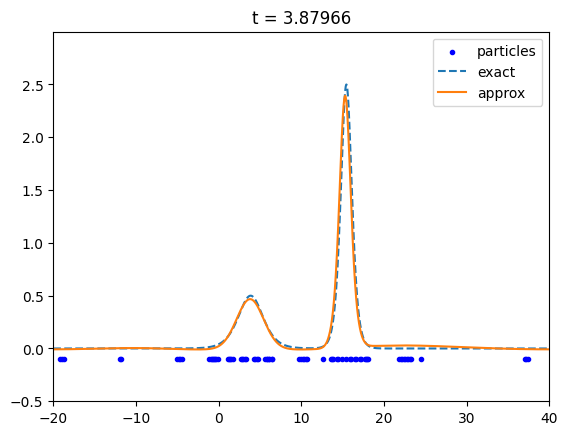

  t = 3.87966
  t = 3.91701
  t = 3.94868
  t = 3.98008


In [12]:
solution_adaptive, timesteps_adaptive = neural_galerkin(theta=theta, # initial parameters
                                                        net=net, # neural network
                                                        problem_data=problem_data, # problem data
                                                        n=100, # sample points
                                                        rhs=rhs_kdv, # problem RHS
                                                        x_init=init_samples_kdv(100).reshape(-1, 1), # particles
                                                        sampler='svgd',
                                                        scheme='rk45'
                                                       )

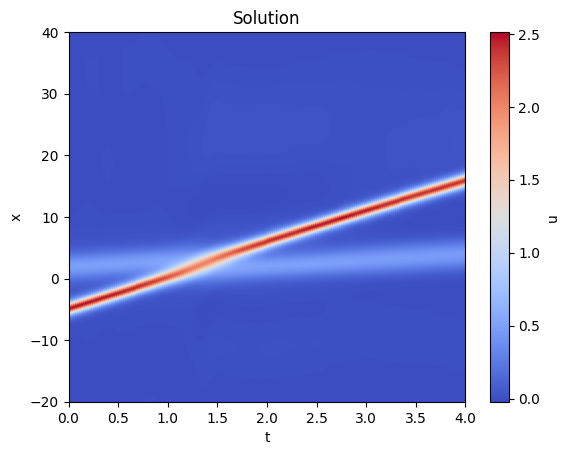

In [13]:
plot_solution(solution_adaptive, timesteps_adaptive, problem_data)

In [14]:
errors_adaptive = compute_error(solution_adaptive, timesteps_adaptive, exactKdVTwoSol, problem_data)

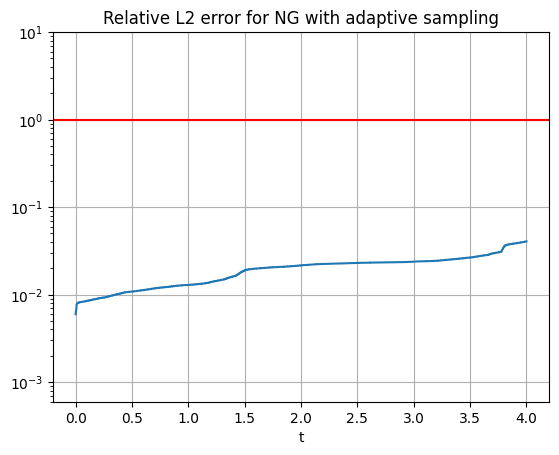

In [15]:
plot_error(errors_adaptive, timesteps_adaptive, 'Relative L2 error for NG with adaptive sampling')

### Final error plot

In [ ]:
errors_list = [errors, errors_linear, errors_equi, errors_adaptive]
timesteps_list = [timesteps, timesteps_linear, timesteps_equi, timesteps_adaptive]
names_list = ['NG', 'linear NG', 'equidistant NG', 'adaptive NG']
plot_error_comparison(errors_list, timesteps_list, names_list)